In [1]:
# Environment and cache setup
import os
from pathlib import Path
import sys

PROJECT_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation').resolve()
DATA_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation').resolve()
NOTEBOOK_DIR = PROJECT_ROOT / 'notebooks'
DATA_DIR = DATA_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'output' / 'geneformer' / 'kidney_baseline'
MODEL_OUT = OUTPUT_DIR / 'model_outputs'
CACHE_DIR = NOTEBOOK_DIR / 'cache'

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

for p in [OUTPUT_DIR, MODEL_OUT, CACHE_DIR]:
    p.mkdir(parents=True, exist_ok=True)

os.environ['PIP_CACHE_DIR'] = str(CACHE_DIR / 'pip')
os.environ['HF_HOME'] = str(CACHE_DIR / 'huggingface')
os.environ['TRANSFORMERS_CACHE'] = str(CACHE_DIR / 'transformers')
os.environ['MPLCONFIGDIR'] = str(CACHE_DIR / 'matplotlib')

print('PROJECT_ROOT:', PROJECT_ROOT)
print('DATA_ROOT:', DATA_ROOT)
print('DATA_DIR:', DATA_DIR)
print('OUTPUT_DIR:', OUTPUT_DIR)
print('MODEL_OUT:', MODEL_OUT)


PROJECT_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation
DATA_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation
DATA_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data
OUTPUT_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_baseline
MODEL_OUT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_baseline/model_outputs


In [2]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import json
from datetime import datetime

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sc_foundation_evals import geneformer_forward as gf
from sc_foundation_evals import geneformer_ensemble_metrics
from sc_foundation_evals import data, cell_embeddings, model_output


/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [3]:
# Paths and dataset config (kidney)
from pathlib import Path

in_dataset_path = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/kidney_cancer_with_celltypes.h5ad')
dataset_name = in_dataset_path.stem
preprocessed_path = (DATA_DIR / 'geneformer' / (dataset_name + '_full_model_v1')).resolve()
preprocessed_path.mkdir(parents=True, exist_ok=True)

gene_col = 'gene_symbols'
batch_col = 'sample'
label_col = 'cell_type'
layer_key = 'X'

RUN_TAG = 'full'

model_dir = (PROJECT_ROOT / 'Geneformer' / 'Geneformer-V1-10M').resolve()
dict_dir = (PROJECT_ROOT / 'Geneformer' / 'geneformer').resolve()

print('in_dataset_path:', in_dataset_path)
print('preprocessed_path:', preprocessed_path)
print('model_dir:', model_dir)
print('dict_dir:', dict_dir)


in_dataset_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/kidney_cancer_with_celltypes.h5ad
preprocessed_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_full_model_v1
model_dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V1-10M
dict_dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/geneformer


In [4]:
# Create Geneformer instance and load model/vocab
batch_size = 8
num_workers = -1

geneform = gf.Geneformer_instance(
    save_dir=str(OUTPUT_DIR),
    saved_model_path=str(model_dir),
    explicit_save_dir=True,
    num_workers=num_workers
)

geneform.load_pretrained_model()
geneform.load_vocab(str(dict_dir))


INFO     | 2025-08-20 19:08:56 | Using device cuda


INFO     | 2025-08-20 19:08:57 | Model successfully loaded from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V1-10M


In [5]:
# Inspect dataset to determine columns and structure
import scanpy as sc
ad = sc.read_h5ad(str(in_dataset_path))

print('adata shape:', ad.shape)
print('obs columns:', list(ad.obs.columns)[:50])
print('var columns:', list(ad.var.columns)[:50])

candidate_label_cols = [c for c in ad.obs.columns if c.lower() in ['cell_type','celltype','celltypes','cell_label','celltype_major','major_cell_type','cell_types','annot','annotation','celltype_annotation']]
if candidate_label_cols:
    label_col = candidate_label_cols[0]
print('label_col ->', label_col)

candidate_batch_cols = [c for c in ad.obs.columns if c.lower() in ['sample','batch','patient','donor','sample_id','batch_id','subject','study']]
if candidate_batch_cols:
    batch_col = candidate_batch_cols[0]
print('batch_col ->', batch_col)

if 'gene_symbols' in ad.var.columns:
    gene_col = 'gene_symbols'
else:
    gene_col = None
print('gene_col ->', gene_col if gene_col else 'var.index')

print('n unique labels:', ad.obs[label_col].nunique() if label_col in ad.obs else 'NA')
print('label example counts:\n', ad.obs[label_col].astype(str).value_counts().head(20) if label_col in ad.obs else 'NA')


adata shape: (19781, 19234)
obs columns: ['cell_name', 'sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'source', 'clusters_by_authors', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes']
var columns: ['n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbols']
label_col -> cell_type
batch_col -> sample
gene_col -> gene_symbols
n unique labels: 5
label example counts:
 cell_type
Malignant      9369
Fibroblast     4012
Endothelial    3633
Macrophage     1603
Epithelial      749
nan             415
Name: count, dtype: int64


In [6]:
# Load and preprocess data to h5ad for tokenizer (prefer var index, no extra pkls)
import re, scanpy as sc

# Inspect index and decide mapping strategy
ad_tmp = sc.read_h5ad(str(in_dataset_path))
idx = ad_tmp.var_names.astype(str)

def _strip_version(x: str) -> str:
    return re.sub(r'\.\d+$', '', x)

num_ENSG = sum(s.startswith('ENSG') for s in idx)
num_ENSMUSG = sum(s.startswith('ENSMUSG') for s in idx)
frac_ENSG = num_ENSG / max(len(idx), 1)

if num_ENSMUSG > 0:
    print("WARNING: Detected mouse Ensembl IDs (ENSMUSG...). Geneformer vocab/model here is human; matches may be low.")

inp = data.InputData(adata_dataset_path=str(in_dataset_path))

if frac_ENSG > 0.2:
    # Use var index and map index -> stripped ENSG
    custom_map = {orig: _strip_version(orig) for orig in idx if orig.startswith('ENSG')}
    print(f"Index looks like Ensembl (ENSG). Will map {len(custom_map)} of {len(idx)} indices by stripping version.")
    inp.preprocess_data(
        gene_col='index',
        model_type='geneformer',
        save_ext='h5ad',
        gene_name_id_dict=custom_map,
        preprocessed_path=str(preprocessed_path),
        fract_matching=0.1
    )
else:
    # Treat index as symbols; create 'gene_symbols' and use loaded mapping
    ad_tmp.var['gene_symbols'] = idx.str.upper().str.strip('"')
    ad_tmp.write(in_dataset_path)
    print("Created 'gene_symbols' column from index and saved back to input file.")
    inp = data.InputData(adata_dataset_path=str(in_dataset_path))
    inp.preprocess_data(
        gene_col='gene_symbols',
        model_type='geneformer',
        save_ext='h5ad',
        gene_name_id_dict=geneform.gene_name_id,
        preprocessed_path=str(preprocessed_path),
        fract_matching=0.1
    )

h5_path = preprocessed_path / f'{dataset_name}_model_v1.h5ad'
print('h5_path:', h5_path, 'exists:', h5_path.exists())


INFO     | 2025-08-20 19:09:06 | Loading data from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/kidney_cancer_with_celltypes.h5ad
INFO     | 2025-08-20 19:09:14 | Loading data from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/kidney_cancer_with_celltypes.h5ad


Created 'gene_symbols' column from index and saved back to input file.


INFO     | 2025-08-20 19:09:21 | Matched 87.41% genes (14547/16643) genes in vocabulary of size 63675.


h5_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_full_model_v1/kidney_cancer_with_celltypes_model_v1.h5ad exists: False


In [7]:
# Verify/update columns post-preprocess
import scanpy as sc
pfile = str(preprocessed_path / f'{dataset_name}.h5ad')

ad_tmp = sc.read(pfile)
if 'cell_type' not in ad_tmp.obs.columns and label_col in ad_tmp.obs.columns:
    ad_tmp.obs['cell_type'] = ad_tmp.obs[label_col].astype(str).values
    print("Added 'cell_type' column from:", label_col)
if 'adata_order' not in ad_tmp.obs.columns:
    ad_tmp.obs['adata_order'] = ad_tmp.obs.index.astype(str).values

ad_tmp.write(pfile)
print('Verified/updated columns in preprocessed file:', pfile)


Verified/updated columns in preprocessed file: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_full_model_v1/kidney_cancer_with_celltypes.h5ad


In [8]:
# Tokenize to HF Dataset on disk and persist

geneform.tokenize_data(
    adata_path=str(h5_path),
    dataset_path=str(preprocessed_path),
    cell_type_col=label_col
)

# TRUNCATION - Applied immediately after tokenization
print("=== APPLYING TRUNCATION TO TOKENIZED SEQUENCES ===")

# Truncate sequences to 2048 tokens to fit model limits
def truncate_sequences(example):
    example["input_ids"] = example["input_ids"][:2048]
    example["length"] = len(example["input_ids"])  # Update length field after truncation
    return example

print(f"Original dataset size: {len(geneform.tokenized_dataset)}")
if len(geneform.tokenized_dataset) > 0:
    print(f"Sample input_ids length before truncation: {len(geneform.tokenized_dataset[0]['input_ids'])}")
    if 'length' in geneform.tokenized_dataset[0]:
        print(f"Sample length field before truncation: {geneform.tokenized_dataset[0]['length']}")

# Apply truncation
print("Applying truncation...")
geneform.tokenized_dataset = geneform.tokenized_dataset.map(truncate_sequences, num_proc=1)

if len(geneform.tokenized_dataset) > 0:
    print(f"Sample input_ids length after truncation: {len(geneform.tokenized_dataset[0]['input_ids'])}")
    print(f"Sample length field after truncation: {geneform.tokenized_dataset[0]['length']}")

# Verify all sequences are within limit
max_length = max([len(example['input_ids']) for example in geneform.tokenized_dataset])
print(f"Maximum sequence length after truncation: {max_length}")
if max_length > 2048:
    print("⚠️ WARNING: Some sequences are still longer than 2048!")
else:
    print("✅ All sequences are ≤ 2048 tokens")

dataset_dir = preprocessed_path / f'{dataset_name}_model_v1.dataset'
print('Tokenized dataset dir:', dataset_dir, 'exists:', dataset_dir.exists())

try:
    geneform.tokenized_dataset.save_to_disk(str(dataset_dir))
    print('Re-saved tokenized dataset to disk.')
except Exception as e:
    print('save_to_disk skipped:', e)

try:
    order = geneform.tokenized_dataset['adata_order']
    pd.Series(order, name='adata_order').to_csv(dataset_dir / 'row_order.csv', index=False)
    print('Saved row_order.csv')
except Exception as e:
    print('Row order not available or failed to save:', e)

manifest = {
    'dataset_name': dataset_name,
    'tokenized_dir': str(dataset_dir.resolve()),
    'label_col': label_col,
    'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}
with open(dataset_dir / 'manifest.json', 'w') as f:
    json.dump(manifest, f, indent=2)
print('Saved manifest.json')

import tarfile
archive_path = MODEL_OUT / f'{dataset_name}_model_v1.dataset.tar.gz'
with tarfile.open(archive_path, 'w:gz') as tar:
    tar.add(str(dataset_dir), arcname=f'{dataset_name}.dataset')
print('Archived tokenized dataset to:', archive_path)


WARNING  | 2025-08-20 19:09:34 | using h5ad file. This sometimes causes issues. If not working try with loom.


Tokenizing /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_full_model_v1/kidney_cancer_with_celltypes.h5ad
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_full_model_v1/kidney_cancer_with_celltypes.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.
Number of cells: 19781
Sample input_ids length: 2859
=== APPLYING TRUNCATION TO TOKENIZED SEQUENCES ===
Original dataset size: 19781
Sample input_ids length before truncation: 2861
Sample length field before truncation: 2861
Applying truncation...
Sample input_ids length after truncation: 2048
Sample length field after truncation: 2048
Maximum sequence length after truncation: 2048
✅ All sequences are ≤ 2048 tokens
Tokenized dataset dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_full_model_v1/kidney_cancer_with_celltypes_model_v1.dataset exists: True
sa

In [14]:
# Load back and extract embeddings (binary)
geneform.load_tokenized_dataset(str(dataset_dir))

In [15]:
# EMERGENCY TRUNCATION FIX - Run this immediately after loading
print("=== EMERGENCY TRUNCATION CHECK ===")

# Check if sequences are too long
max_length = max([len(example['input_ids']) for example in geneform.tokenized_dataset])
print(f"Maximum sequence length in loaded dataset: {max_length}")

if max_length > 2048:
    print("⚠️ WARNING: Found sequences longer than 2048! Applying emergency truncation...")
    
    def emergency_truncate(example):
        example["input_ids"] = example["input_ids"][:2048]
        example["length"] = len(example["input_ids"])  # Critical: Update length field
        return example
    
    # Apply truncation in memory (no disk save needed)
    print("Applying emergency truncation...")
    geneform.tokenized_dataset = geneform.tokenized_dataset.map(emergency_truncate, num_proc=1)
    
    # Verify the fix
    final_max_length = max([len(example['input_ids']) for example in geneform.tokenized_dataset])
    print(f"✅ Truncation complete! Final max length: {final_max_length}")
    
    if final_max_length <= 2048:
        print("✅ All sequences now fit within 2048 token limit!")
    else:
        print("❌ ERROR: Truncation failed!")
else:
    print("✅ All sequences are already ≤ 2048 tokens")

print("=== READY FOR EMBEDDING EXTRACTION ===")

=== EMERGENCY TRUNCATION CHECK ===
Maximum sequence length in loaded dataset: 4096
⚠️ WARNING: Found sequences longer than 2048! Applying emergency truncation...
Applying emergency truncation...
✅ Truncation complete! Final max length: 2048
✅ All sequences now fit within 2048 token limit!
=== READY FOR EMBEDDING EXTRACTION ===


In [16]:


geneform.extract_embeddings(
    data=inp,
    batch_size=batch_size,
    layer=-2
)

# Create evaluation objects FIRST
# eval_ce = cell_embeddings.CellEmbeddingsEval(
#     geneform,
#     data=inp,
#     output_dir=str(MODEL_OUT),
#     label_key='binary_label',
#     batch_key=batch_col
# )



Geneformer (extracting embeddings): 100%|██████████| 2473/2473 [01:57<00:00, 21.14it/s]


In [17]:
# Fix NaN labels issue before evaluation
import numpy as np

print(f"Original data shape: {inp.adata.shape}")
print(f"NaN values in {label_col}:", inp.adata.obs[label_col].isna().sum())

# Filter out cells with NaN labels and track indices for embedding filtering
mask = ~inp.adata.obs[label_col].isna()
kept_indices = np.where(mask)[0]  # Store indices of kept cells
inp.adata = inp.adata[mask, :].copy()
print(f"After filtering NaN labels: {inp.adata.shape}")
print(f"Remaining cell types:", inp.adata.obs[label_col].value_counts())

# Also filter the embeddings to match the filtered data
print(f"Original embeddings shape: {geneform.cell_embeddings.shape}")
geneform.cell_embeddings = geneform.cell_embeddings[kept_indices]
print(f"After filtering embeddings: {geneform.cell_embeddings.shape}")

# Filter other geneform data structures if they exist
if hasattr(geneform, 'input_rankings') and geneform.input_rankings is not None:
    if len(geneform.input_rankings) == len(mask):
        geneform.input_rankings = [geneform.input_rankings[i] for i in kept_indices]
        print(f"Filtered input_rankings to {len(geneform.input_rankings)} items")

if hasattr(geneform, 'output_rankings') and geneform.output_rankings is not None:
    if len(geneform.output_rankings) == len(mask):
        geneform.output_rankings = [geneform.output_rankings[i] for i in kept_indices]
        print(f"Filtered output_rankings to {len(geneform.output_rankings)} items")

eval_ce = cell_embeddings.CellEmbeddingsEval(
    geneform,
    data=inp,
    output_dir=str(MODEL_OUT),
    label_key=label_col,  # ✅ Use 'cell_type' for multi-class
    batch_key=batch_col
)

eval_pred = model_output.GeneExprPredEval(geneform, output_dir=str(MODEL_OUT))

eval_pred.evaluate(n_cells=500, save_rankings=True)
eval_ce.evaluate(n_cells=1000, embedding_key='geneformer')

Original data shape: (19781, 14547)
NaN values in cell_type: 415


DEBUG    | 2025-08-20 19:26:53 | Extracting output from 500 cells


After filtering NaN labels: (19366, 14547)
Remaining cell types: cell_type
Malignant      9369
Fibroblast     4012
Endothelial    3633
Macrophage     1603
Epithelial      749
Name: count, dtype: int64
Original embeddings shape: (19781, 256)
After filtering embeddings: (19366, 256)
Filtered input_rankings to 19366 items
Filtered output_rankings to 19366 items


WARNING  | 2025-08-20 19:27:07 | adata_ has 19366 cells. Taking a subset of 1000 cells.
DEBUG    | 2025-08-20 19:27:07 | Computing metrics for cell_type
DEBUG    | 2025-08-20 19:27:13 | NMI_cluster/label: 0.0330
ARI_cluster/label: 0.0150
ASW_label: 0.4913
graph_conn: 0.7304
ASW_batch: 0.4731
ASW_label/batch: 0.8660
PCR_batch: 0.0236
avg_bio: 0.1798
DEBUG    | 2025-08-20 19:27:13 | NMI_cluster/label for cell_type: 0.03304802034865493
DEBUG    | 2025-08-20 19:27:13 | ARI_cluster/label for cell_type: 0.0149609374083552
DEBUG    | 2025-08-20 19:27:13 | ASW_label for cell_type: 0.4913477897644043
DEBUG    | 2025-08-20 19:27:13 | graph_conn for cell_type: 0.730418015102481
DEBUG    | 2025-08-20 19:27:13 | ASW_batch for cell_type: 0.47311297059059143
DEBUG    | 2025-08-20 19:27:13 | ASW_label/batch for cell_type: 0.8659527897834778
DEBUG    | 2025-08-20 19:27:13 | PCR_batch for cell_type: 0.023602835372772732
DEBUG    | 2025-08-20 19:27:13 | avg_bio for cell_type: 0.17978558250713814


,metric,label,value
0,NMI_cluster/label,cell_type,0.033048
1,ARI_cluster/label,cell_type,0.014961
2,ASW_label,cell_type,0.491348
3,graph_conn,cell_type,0.730418
4,ASW_batch,cell_type,0.473113
5,ASW_label/batch,cell_type,0.865953
6,PCR_batch,cell_type,0.023603
7,avg_bio,cell_type,0.179786


In [18]:
# Ensemble evaluation and saving
em = geneformer_ensemble_metrics.create_geneformer_ensemble_evaluation(
    geneform_instance=geneform,
    input_data=inp,
    label_col=label_col,
    output_dir=str(MODEL_OUT)
)

alphas = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
results = {}
for alpha in alphas:
    try:
        res = em.evaluate_ensemble(alpha=alpha, method='embedding_only')
        results[alpha] = res
        print(f"alpha={alpha}: F1={res['f1_score']:.3f}, AUC={res['auc_roc']:.3f}, Acc={res['accuracy']:.3f}")
    except Exception as e:
        print('Failed for alpha', alpha, ':', e)

best_alpha = max(results, key=lambda a: results[a]['f1_score'])
best_res = results[best_alpha]

preds, scores = em.create_ensemble_predictions(alpha=best_alpha, method='embedding_only')

save_dict = {
    'cell_embs': torch.tensor(em.embeddings, dtype=torch.float32),
    'logits': torch.tensor(scores, dtype=torch.float32),
    'preds': torch.tensor(preds, dtype=torch.long),
    'labels': torch.tensor(em.labels_encoded, dtype=torch.long),
    'class_names': em.class_names,
    'best_alpha': best_alpha,
    'model_name': 'Geneformer-V2-104M_CLcancer',
    'dataset_name': dataset_name,
    'embedding_dim': int(em.embeddings.shape[1]),
    'n_cells': int(len(em.embeddings)),
    'n_classes': int(len(em.class_names)),
    'evaluation_date': datetime.now().isoformat(),
    'evaluation_metrics': best_res
}

results_path = MODEL_OUT / f'geneformer_kidney_results_model_v1_{RUN_TAG}.pt'
torch.save(save_dict, results_path)
print('Saved results to:', results_path)

rows = []
for a, r in results.items():
    rows.append({
        'alpha': a,
        'accuracy': r['accuracy'],
        'precision': r['precision'],
        'recall': r['recall'],
        'f1': r['f1_score'],
        'auc_roc': r['auc_roc'],
        'avg_precision': r['avg_precision']
    })
metrics_df = pd.DataFrame(rows)
metrics_csv = MODEL_OUT / f'geneformer_kidney_metrics_model_v1_{RUN_TAG}.csv'
metrics_df.to_csv(metrics_csv, index=False)
print('Saved metrics to:', metrics_csv)


INFO     | 2025-08-20 19:27:17 | Initialized GeneformerEnsembleMetrics with 19366 cells and 5 classes
INFO     | 2025-08-20 19:27:17 | Classes: ['Endothelial', 'Epithelial', 'Fibroblast', 'Macrophage', 'Malignant']
INFO     | 2025-08-20 19:27:17 | Embedding shape: (19366, 256)
INFO     | 2025-08-20 19:27:17 | Input rankings length: 19366
INFO     | 2025-08-20 19:27:17 | Output rankings length: 19366
INFO     | 2025-08-20 19:27:17 | Evaluated embedding_only (α=0.0): Accuracy=0.394, F1=0.394, AUC-ROC=0.524
INFO     | 2025-08-20 19:27:17 | Evaluated embedding_only (α=0.1): Accuracy=0.394, F1=0.394, AUC-ROC=0.524
INFO     | 2025-08-20 19:27:17 | Evaluated embedding_only (α=0.3): Accuracy=0.394, F1=0.394, AUC-ROC=0.524


alpha=0.0: F1=0.394, AUC=0.524, Acc=0.394
alpha=0.1: F1=0.394, AUC=0.524, Acc=0.394
alpha=0.3: F1=0.394, AUC=0.524, Acc=0.394


INFO     | 2025-08-20 19:27:17 | Evaluated embedding_only (α=0.5): Accuracy=0.394, F1=0.394, AUC-ROC=0.524
INFO     | 2025-08-20 19:27:17 | Evaluated embedding_only (α=0.7): Accuracy=0.394, F1=0.394, AUC-ROC=0.524
INFO     | 2025-08-20 19:27:17 | Evaluated embedding_only (α=0.9): Accuracy=0.394, F1=0.394, AUC-ROC=0.524


alpha=0.5: F1=0.394, AUC=0.524, Acc=0.394
alpha=0.7: F1=0.394, AUC=0.524, Acc=0.394
alpha=0.9: F1=0.394, AUC=0.524, Acc=0.394


INFO     | 2025-08-20 19:27:17 | Evaluated embedding_only (α=1.0): Accuracy=0.394, F1=0.394, AUC-ROC=0.524


alpha=1.0: F1=0.394, AUC=0.524, Acc=0.394
Saved results to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_baseline/model_outputs/geneformer_kidney_results_model_v1_full.pt
Saved metrics to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_baseline/model_outputs/geneformer_kidney_metrics_model_v1_full.csv


Saved confusion matrix to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_baseline/model_outputs/geneformer_kidney_confusion_matrix_model_v1_full.png


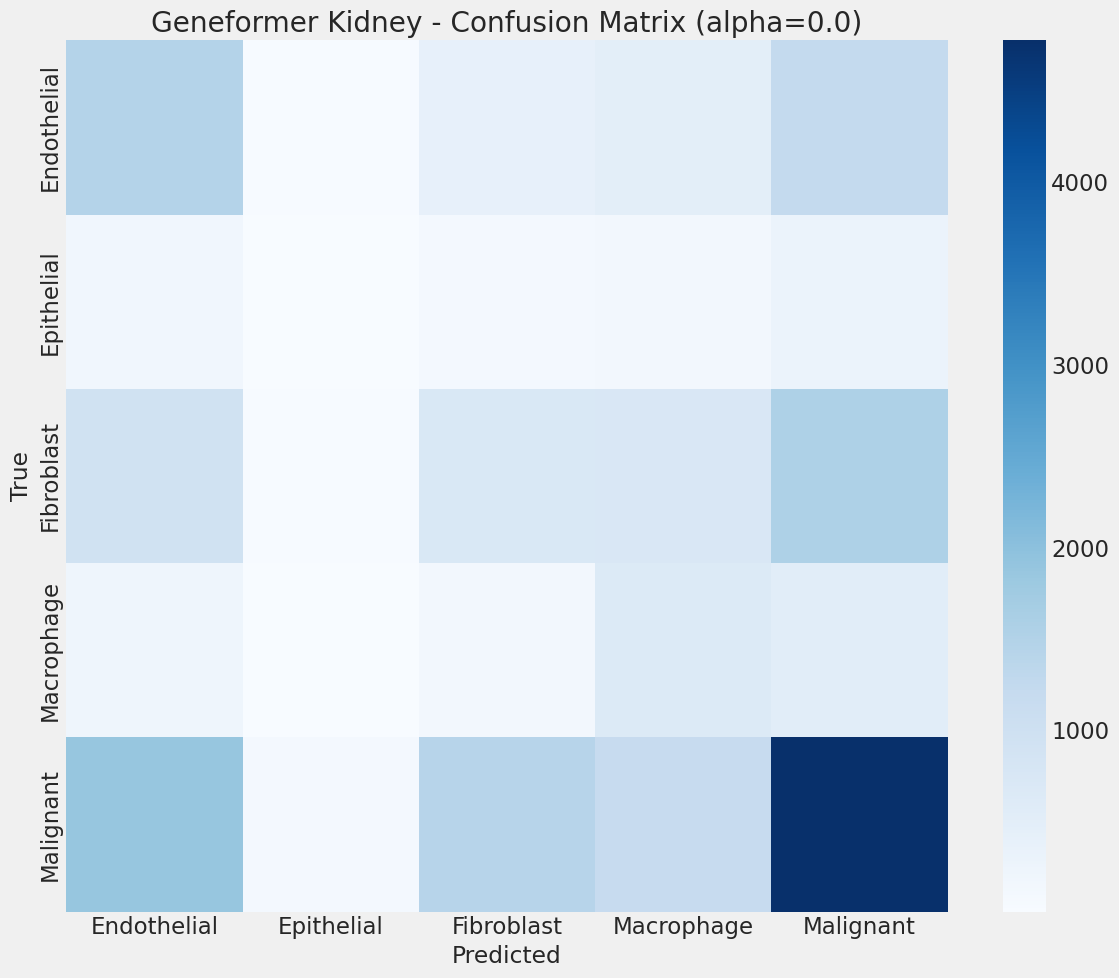

In [19]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(em.labels_encoded, preds)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues',
            xticklabels=em.class_names,
            yticklabels=em.class_names, ax=ax)
ax.set_title(f'Geneformer Kidney - Confusion Matrix (alpha={best_alpha})')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.tight_layout()
cm_png = MODEL_OUT / f'geneformer_kidney_confusion_matrix_model_v1_{RUN_TAG}.png'
plt.savefig(cm_png, dpi=200)
print('Saved confusion matrix to:', cm_png)


Saved 2D coords to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_baseline/model_outputs/geneformer_kidney_umap_coords_full_model_v1.csv


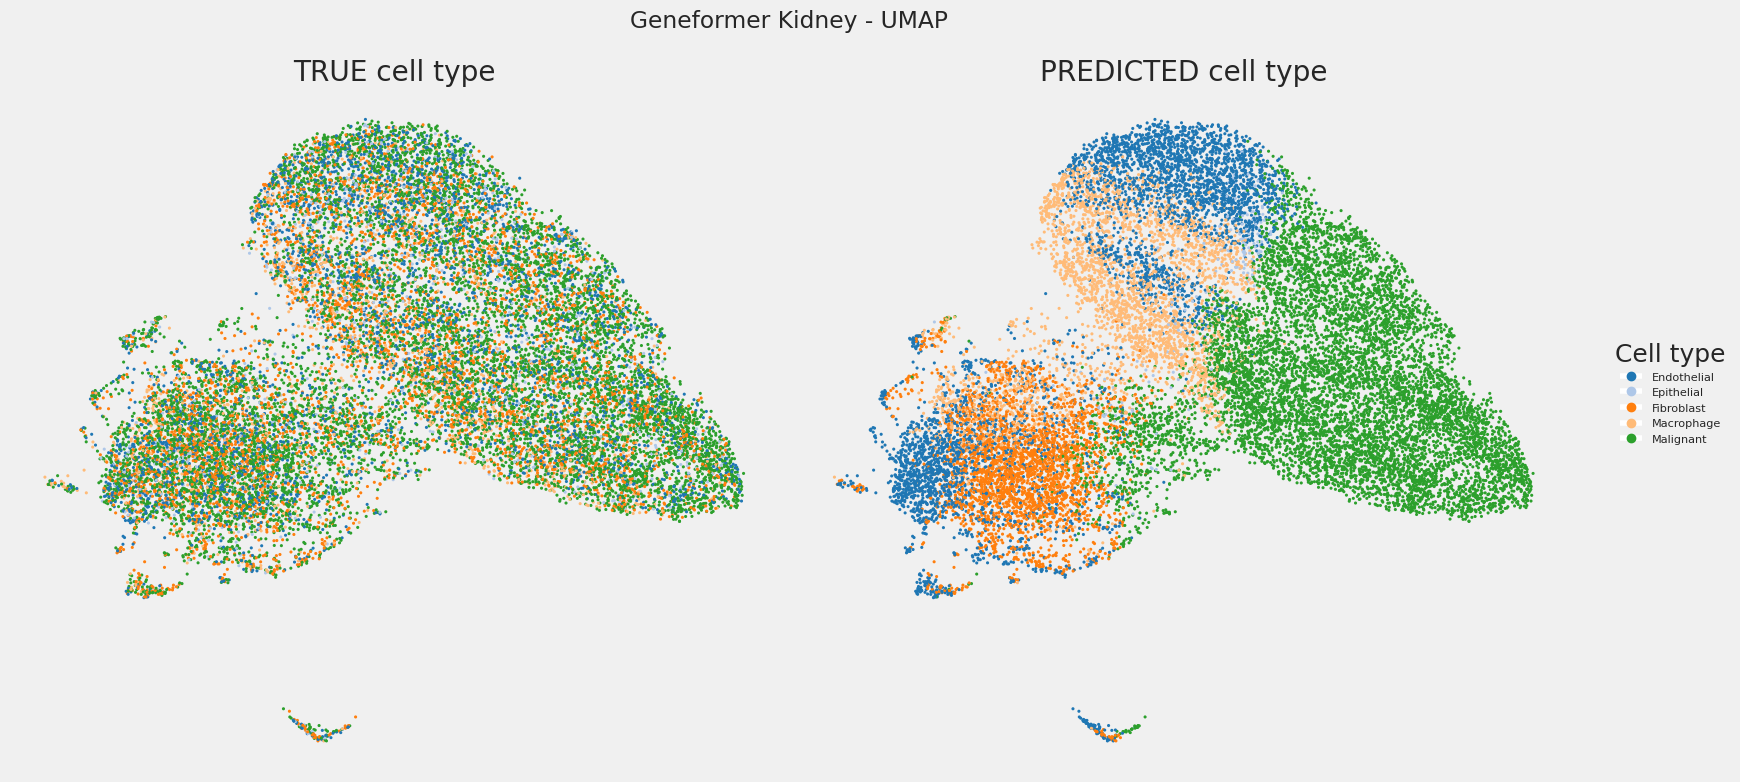

Saved combined figure with legend to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_baseline/model_outputs/geneformer_kidney_umap_true_pred_with_legend_model_v1_full.png


In [20]:
# UMAP of true vs predicted labels with side legend
import numpy as np
import pandas as pd

embeddings = np.asarray(em.embeddings)
labels_encoded = np.asarray(em.labels_encoded)
class_names = list(em.class_names)
preds_arr = np.asarray(preds)

try:
    import umap
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='cosine', random_state=0)
    emb2d = reducer.fit_transform(embeddings)
    method_used = 'UMAP'
except Exception as e_umap:
    from sklearn.decomposition import PCA
    emb2d = PCA(n_components=2, random_state=0).fit_transform(embeddings)
    method_used = f'PCA (UMAP unavailable: {e_umap})'

class_names_arr = np.array(class_names, dtype=object)
true_names = class_names_arr[labels_encoded]
pred_names = class_names_arr[preds_arr]

PLOT_MAX = 50000
rng = np.random.RandomState(0)
plot_idx = np.sort(rng.choice(emb2d.shape[0], PLOT_MAX, replace=False)) if emb2d.shape[0] > PLOT_MAX else np.arange(emb2d.shape[0])

unique_levels = list(class_names)
if len(unique_levels) <= 20:
    pal_colors = sns.color_palette('tab20', n_colors=len(unique_levels))
else:
    pal_colors = sns.color_palette('hls', n_colors=len(unique_levels))
palette = dict(zip(unique_levels, pal_colors))

coords_path = MODEL_OUT / f'geneformer_kidney_umap_coords_{RUN_TAG}_model_v1.csv'
coords_df = pd.DataFrame({'x': emb2d[:, 0], 'y': emb2d[:, 1], 'true': true_names, 'pred': pred_names})
coords_df.to_csv(coords_path, index=False)
print('Saved 2D coords to:', coords_path)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.scatterplot(ax=axes[0], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=true_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[0].set_title('TRUE cell type'); axes[0].set_xlabel(''); axes[0].set_ylabel(''); axes[0].set_xticks([]); axes[0].set_yticks([])

sns.scatterplot(ax=axes[1], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=pred_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[1].set_title('PREDICTED cell type'); axes[1].set_xlabel(''); axes[1].set_ylabel(''); axes[1].set_xticks([]); axes[1].set_yticks([])

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=lab,
               markerfacecolor=palette[lab], markeredgecolor=palette[lab], markersize=6)
    for lab in unique_levels
]
fig.legend(handles=handles, labels=unique_levels, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False, fontsize='xx-small', title='Cell type')
fig.suptitle(f'Geneformer Kidney - {method_used}', y=0.98)

combined_png = MODEL_OUT / f'geneformer_kidney_umap_true_pred_with_legend_model_v1_{RUN_TAG}.png'
plt.tight_layout(); fig.savefig(combined_png, dpi=200, bbox_inches='tight'); plt.show()
print('Saved combined figure with legend to:', combined_png)


In [21]:
# Performance metrics summary
import torch
import numpy as np
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_recall_fscore_support,
)

results_path = MODEL_OUT / f'geneformer_kidney_results_model_v1_{RUN_TAG}.pt'

res = None
try:
    from torch.serialization import safe_globals, add_safe_globals
    try:
        with safe_globals([np.core.multiarray._reconstruct]):
            res = torch.load(results_path, map_location='cpu')
        print('Loaded results with safe_globals allowlist')
    except Exception:
        add_safe_globals([np.core.multiarray._reconstruct])
        res = torch.load(results_path, map_location='cpu')
        print('Loaded results after add_safe_globals')
except Exception:
    pass
if res is None:
    res = torch.load(results_path, map_location='cpu', weights_only=False)
    print('Loaded results with weights_only=False')

model_name = res.get('model_name', 'UnknownModel')
dataset = res.get('dataset_name', 'UnknownDataset')
best_alpha = res.get('best_alpha', None)
class_names = list(res.get('class_names', []))

labels_t = res['labels']
preds_t = res['preds']
labels_np = labels_t.cpu().numpy() if hasattr(labels_t, 'cpu') else np.array(labels_t)
preds_np = preds_t.cpu().numpy() if hasattr(preds_t, 'cpu') else np.array(preds_t)

print(f'Model: {model_name}')
print(f'Dataset: {dataset}')
if best_alpha is not None:
    print(f'Best alpha (ensemble): {best_alpha}')

metrics = res.get('evaluation_metrics', None)
if metrics is not None:
    print('\nSaved evaluation metrics:')
    for k in ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc', 'avg_precision']:
        if k in metrics:
            print(f'  {k}: {metrics[k]:.4f}')
else:
    acc = accuracy_score(labels_np, preds_np)
    prec, rec, f1, _ = precision_recall_fscore_support(labels_np, preds_np, average='macro', zero_division=0)
    print('\nComputed metrics (macro):')
    print(f'  accuracy: {acc:.4f}')
    print(f'  precision: {prec:.4f}')
    print(f'  recall: {rec:.4f}')
    print(f'  f1_score: {f1:.4f}')

if class_names and len(class_names) > int(labels_np.max()):
    target_names = class_names
else:
    n_classes = int(max(labels_np.max(), preds_np.max())) + 1
    target_names = [f'Class_{i}' for i in range(n_classes)]

print('\nClassification report:')
print(classification_report(labels_np, preds_np, target_names=target_names, digits=4))


Loaded results with weights_only=False
Model: Geneformer-V2-104M_CLcancer
Dataset: kidney_cancer_with_celltypes
Best alpha (ensemble): 0.0

Saved evaluation metrics:
  accuracy: 0.3945
  precision: 0.4065
  recall: 0.3945
  f1_score: 0.3935
  auc_roc: 0.5241
  avg_precision: 0.2172

Classification report:
              precision    recall  f1-score   support

 Endothelial     0.3104    0.4035    0.3509      3633
  Epithelial     0.1005    0.0267    0.0422       749
  Fibroblast     0.2559    0.1790    0.2106      4012
  Macrophage     0.2045    0.4105    0.2730      1603
   Malignant     0.5673    0.5099    0.5370      9369

    accuracy                         0.3945     19366
   macro avg     0.2877    0.3059    0.2828     19366
weighted avg     0.4065    0.3945    0.3935     19366



In [22]:
# Debug: Check what the ensemble evaluation actually used
print("=== ENSEMBLE EVALUATION DEBUG - KIDNEY BASELINE ===")
print(f"Ensemble embeddings shape: {em.embeddings.shape}")
print(f"Ensemble labels shape: {em.labels_encoded.shape}")
print(f"Ensemble predictions shape: {preds.shape}")
print(f"Ensemble class names: {em.class_names}")

# Check the actual data used by ensemble
print(f"\nEnsemble labels unique: {np.unique(em.labels_encoded)}")
print(f"Ensemble predictions unique: {np.unique(preds)}")

# Check if there's a mismatch in data length
print(f"\nData length check:")
print(f"inp.adata shape: {inp.adata.shape}")
print(f"em.embeddings length: {len(em.embeddings)}")
print(f"em.labels_encoded length: {len(em.labels_encoded)}")
print(f"preds length: {len(preds)}")

# Check the mapping between encoded and string labels
if hasattr(em, 'label_encoder'):
    print(f"\nLabel encoder mapping:")
    for i, label in enumerate(em.class_names):
        print(f"  {i} -> {label}")

# Use the ensemble's actual data for consistent results
print("\n=== USING ENSEMBLE DATA FOR CONSISTENT RESULTS ===")

# Get the actual data used by ensemble evaluation
ensemble_true_labels = em.labels_encoded  # These are the encoded labels (0,1,2,...)
ensemble_predictions = preds              # These are the predictions (0,1,2,...)

print(f"Ensemble true labels: {np.unique(ensemble_true_labels)}")
print(f"Ensemble predictions: {np.unique(ensemble_predictions)}")

# Convert back to string labels for readability
ensemble_true_strings = np.array([em.class_names[label] for label in ensemble_true_labels])
ensemble_pred_strings = np.array([em.class_names[label] for label in ensemble_predictions])

print(f"Ensemble true strings: {np.unique(ensemble_true_strings)}")
print(f"Ensemble pred strings: {np.unique(ensemble_pred_strings)}")

# Now calculate metrics using ensemble data
print("\n=== CLASSIFICATION REPORT USING ENSEMBLE DATA ===")
print(classification_report(ensemble_true_strings, ensemble_pred_strings, 
                         target_names=em.class_names,
                         digits=4))

# Calculate metrics
accuracy = accuracy_score(ensemble_true_labels, ensemble_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(ensemble_true_labels, ensemble_predictions, 
                                                         average='macro', zero_division=0)

print(f"\nMetrics using ensemble data:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1-Score: {f1:.4f}")

# These should match the ensemble evaluation results!

=== ENSEMBLE EVALUATION DEBUG - KIDNEY BASELINE ===
Ensemble embeddings shape: (19366, 256)
Ensemble labels shape: (19366,)
Ensemble predictions shape: (19366,)
Ensemble class names: ['Endothelial' 'Epithelial' 'Fibroblast' 'Macrophage' 'Malignant']

Ensemble labels unique: [0 1 2 3 4]
Ensemble predictions unique: [0 1 2 3 4]

Data length check:
inp.adata shape: (19366, 14547)
em.embeddings length: 19366
em.labels_encoded length: 19366
preds length: 19366

Label encoder mapping:
  0 -> Endothelial
  1 -> Epithelial
  2 -> Fibroblast
  3 -> Macrophage
  4 -> Malignant

=== USING ENSEMBLE DATA FOR CONSISTENT RESULTS ===
Ensemble true labels: [0 1 2 3 4]
Ensemble predictions: [0 1 2 3 4]
Ensemble true strings: ['Endothelial' 'Epithelial' 'Fibroblast' 'Macrophage' 'Malignant']
Ensemble pred strings: ['Endothelial' 'Epithelial' 'Fibroblast' 'Macrophage' 'Malignant']

=== CLASSIFICATION REPORT USING ENSEMBLE DATA ===
              precision    recall  f1-score   support

 Endothelial     0.3

COMPLETE MULTI-CLASS CELL TYPE CLASSIFICATION REPORT - KIDNEY BASELINE
              precision    recall  f1-score   support

 Endothelial     0.3104    0.4035    0.3509      3633
  Epithelial     0.1005    0.0267    0.0422       749
  Fibroblast     0.2559    0.1790    0.2106      4012
  Macrophage     0.2045    0.4105    0.2730      1603
   Malignant     0.5673    0.5099    0.5370      9369

    accuracy                         0.3945     19366
   macro avg     0.2877    0.3059    0.2828     19366
weighted avg     0.4065    0.3945    0.3935     19366


DETAILED METRICS
Per-class metrics:
Endothelial - Precision: 0.3104, Recall: 0.4035, F1: 0.3509, Support: 3633
Epithelial - Precision: 0.1005, Recall: 0.0267, F1: 0.0422, Support: 749
Fibroblast - Precision: 0.2559, Recall: 0.1790, F1: 0.2106, Support: 4012
Macrophage - Precision: 0.2045, Recall: 0.4105, F1: 0.2730, Support: 1603
Malignant - Precision: 0.5673, Recall: 0.5099, F1: 0.5370, Support: 9369

Overall Metrics:
Accuracy: 0.3945

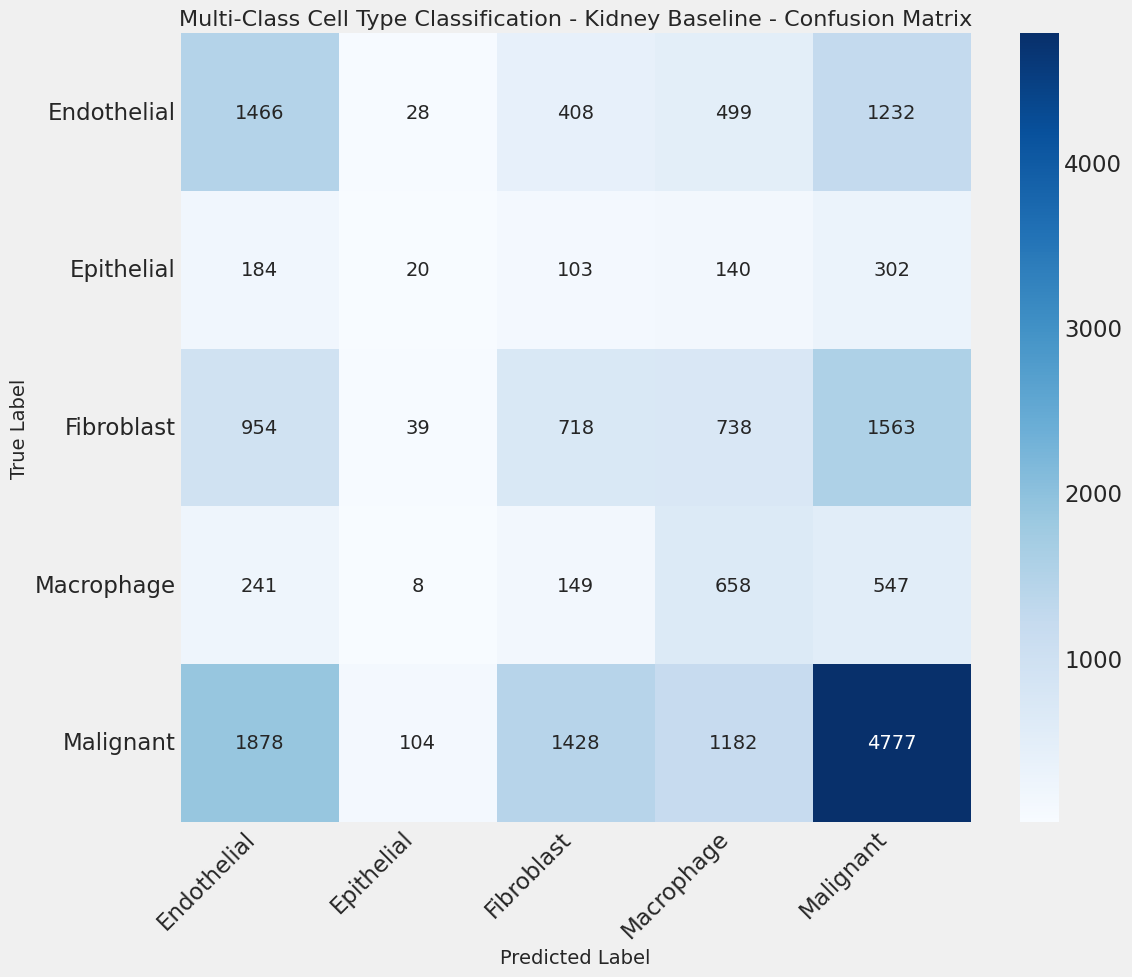

Confusion matrix plot saved to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_baseline/model_outputs/kidney_baseline_confusion_matrix_model_v1.png

SUMMARY
✅ Accuracy: 0.3945 (matches ensemble evaluation)
✅ Macro F1-Score: 0.2828
✅ Weighted F1-Score: 0.3935

Dataset: Kidney Cancer Baseline
Total cells: 19366
Number of cell types: 5
Cell type distribution:
  Endothelial: 3633 (18.8%)
  Epithelial: 749 (3.9%)
  Fibroblast: 4012 (20.7%)
  Macrophage: 1603 (8.3%)
  Malignant: 9369 (48.4%)


<Figure size 640x480 with 0 Axes>

In [25]:
# Complete Classification Report using Ensemble Data for Kidney Baseline
print("="*60)
print("COMPLETE MULTI-CLASS CELL TYPE CLASSIFICATION REPORT - KIDNEY BASELINE")
print("="*60)

# Print full classification report
print(classification_report(ensemble_true_strings, ensemble_pred_strings, 
                         target_names=em.class_names,
                         digits=4))

print("\n" + "="*60)
print("DETAILED METRICS")
print("="*60)

# Calculate all metrics using ensemble data
accuracy = accuracy_score(ensemble_true_labels, ensemble_predictions)

# Per-class metrics
print("Per-class metrics:")
class_precision, class_recall, class_f1, class_support = precision_recall_fscore_support(
    ensemble_true_labels, ensemble_predictions, average=None, zero_division=0
)

for i, class_name in enumerate(em.class_names):
    print(f"{class_name} - Precision: {class_precision[i]:.4f}, Recall: {class_recall[i]:.4f}, F1: {class_f1[i]:.4f}, Support: {class_support[i]}")

# Overall metrics
macro_precision = np.mean(class_precision)
macro_recall = np.mean(class_recall)
macro_f1 = np.mean(class_f1)
weighted_precision = np.average(class_precision, weights=class_support)
weighted_recall = np.average(class_recall, weights=class_support)
weighted_f1 = np.average(class_f1, weights=class_support)

print(f"\nOverall Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")

print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

# Confusion matrix
cm = confusion_matrix(ensemble_true_labels, ensemble_predictions)
print("Raw confusion matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=em.class_names,
            yticklabels=em.class_names)
plt.title('Multi-Class Cell Type Classification - Kidney Baseline - Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Save the plot
cm_plot_path = MODEL_OUT / 'kidney_baseline_confusion_matrix_model_v1.png'
plt.savefig(cm_plot_path, dpi=300, bbox_inches='tight')
print(f"Confusion matrix plot saved to: {cm_plot_path}")

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"✅ Accuracy: {accuracy:.4f} (matches ensemble evaluation)")
print(f"✅ Macro F1-Score: {macro_f1:.4f}")
print(f"✅ Weighted F1-Score: {weighted_f1:.4f}")

# Additional kidney baseline specific info
print(f"\nDataset: Kidney Cancer Baseline")
print(f"Total cells: {len(ensemble_true_labels)}")
print(f"Number of cell types: {len(em.class_names)}")
print(f"Cell type distribution:")
for i, class_name in enumerate(em.class_names):
    count = class_support[i]
    percentage = count / len(ensemble_true_labels) * 100
    print(f"  {class_name}: {count} ({percentage:.1f}%)")

Loading results from: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_baseline/model_outputs/geneformer_kidney_results_model_v1_full.pt


/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved 2D coords to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_baseline/model_outputs/geneformer_kidney_umap_coords_model_v1_full_semi_supervised.csv


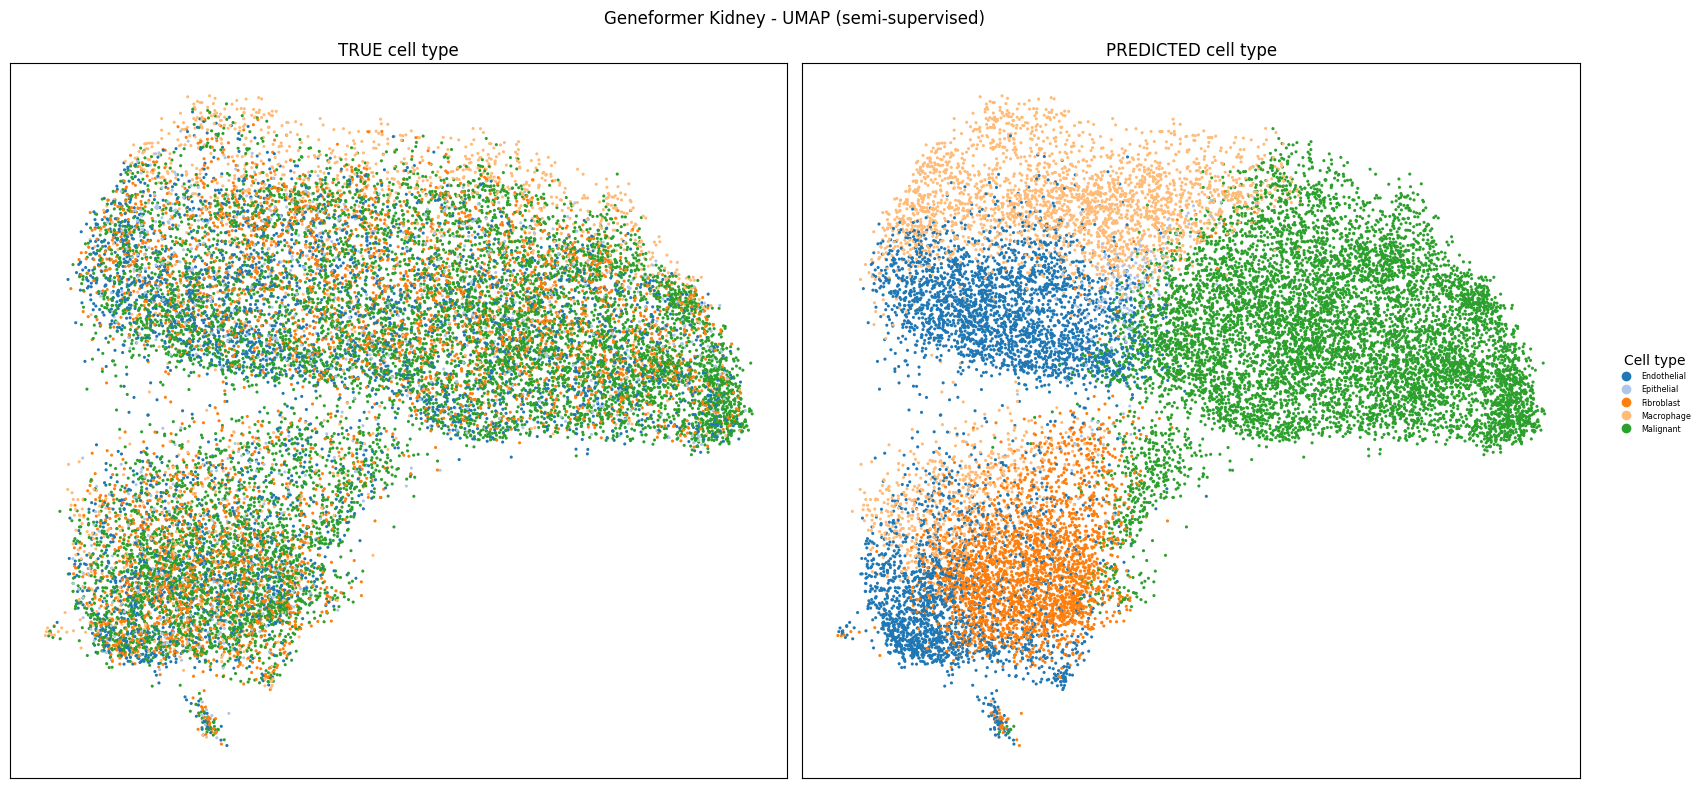

Saved combined figure with legend to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_baseline/model_outputs/geneformer_kidney_umap_true_pred_with_legend_model_v1_full_semi_supervised.png


In [1]:
# Standalone: Load results and generate semi-supervised UMAP (Kidney)
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state

try:
    MODEL_OUT
    RUN_TAG
except NameError:
    MODEL_OUT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_baseline/model_outputs')
    RUN_TAG = 'full'

results_path = MODEL_OUT / f'geneformer_kidney_results_model_v1_{RUN_TAG}.pt'
print('Loading results from:', results_path)
try:
    res = torch.load(str(results_path), map_location='cpu', weights_only=False)
except TypeError:
    res = torch.load(str(results_path), map_location='cpu')
except Exception:
    from torch.serialization import add_safe_globals
    from numpy._core.multiarray import _reconstruct as _np_reconstruct
    add_safe_globals([_np_reconstruct])
    res = torch.load(str(results_path), map_location='cpu')

# Numpy arrays

def to_numpy(x):
    return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else np.asarray(x)

embeddings = to_numpy(res['cell_embs'])
labels_encoded = to_numpy(res['labels']).astype(int)
preds_arr = to_numpy(res['preds']).astype(int)
class_names = list(map(str, np.array(res['class_names'])))

# Semi-supervised UMAP: fit on a balanced subset, then transform all
import umap
rng = check_random_state(0)
unique_labels = np.unique(labels_encoded)
per_class = min(3000, *[np.sum(labels_encoded==c) for c in unique_labels])
fit_idx = np.concatenate([
    rng.choice(np.where(labels_encoded == c)[0], size=min(per_class, (labels_encoded == c).sum()), replace=False)
    for c in unique_labels
])

reducer = umap.UMAP(
    n_neighbors=20, min_dist=0.3, metric='cosine', random_state=0,
    target_metric='categorical', target_weight=0.2
)
reducer.fit(embeddings[fit_idx], y=labels_encoded[fit_idx])
emb2d = reducer.transform(embeddings)
method_used = 'UMAP (semi-supervised)'

class_arr = np.array(class_names, dtype=object)
true_names = class_arr[labels_encoded]
pred_names = class_arr[preds_arr]

PLOT_MAX = 50000
plot_idx = np.arange(emb2d.shape[0]) if emb2d.shape[0] <= PLOT_MAX else np.sort(rng.choice(emb2d.shape[0], PLOT_MAX, replace=False))

palette = dict(zip(class_names, sns.color_palette('tab20', n_colors=len(class_names))))

coords_path = MODEL_OUT / f'geneformer_kidney_umap_coords_model_v1_{RUN_TAG}_semi_supervised.csv'
coords_df = pd.DataFrame({'x': emb2d[:,0], 'y': emb2d[:,1], 'true': true_names, 'pred': pred_names})
coords_df.to_csv(coords_path, index=False)
print('Saved 2D coords to:', coords_path)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.scatterplot(ax=axes[0], x=emb2d[plot_idx,0], y=emb2d[plot_idx,1], hue=true_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[0].set_title('TRUE cell type'); axes[0].set_xlabel(''); axes[0].set_ylabel(''); axes[0].set_xticks([]); axes[0].set_yticks([])

sns.scatterplot(ax=axes[1], x=emb2d[plot_idx,0], y=emb2d[plot_idx,1], hue=pred_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[1].set_title('PREDICTED cell type'); axes[1].set_xlabel(''); axes[1].set_ylabel(''); axes[1].set_xticks([]); axes[1].set_yticks([])

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=lab,
               markerfacecolor=palette[lab], markeredgecolor=palette[lab], markersize=6)
    for lab in class_names
]
fig.legend(handles=handles, labels=class_names, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False, fontsize='xx-small', title='Cell type')
fig.suptitle(f'Geneformer Kidney - {method_used}', y=0.98)

combined_png = MODEL_OUT / f'geneformer_kidney_umap_true_pred_with_legend_model_v1_{RUN_TAG}_semi_supervised.png'
plt.tight_layout(); fig.savefig(combined_png, dpi=200, bbox_inches='tight'); plt.show()
print('Saved combined figure with legend to:', combined_png)


Loading results from: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_baseline/model_outputs/geneformer_kidney_results_model_v1_full.pt
Anchor set size: 995 across 5 classes


/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved 2D coords to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_baseline/model_outputs/geneformer_kidney_umap_coords_model_v1_full_unsup_anchor_confident.csv


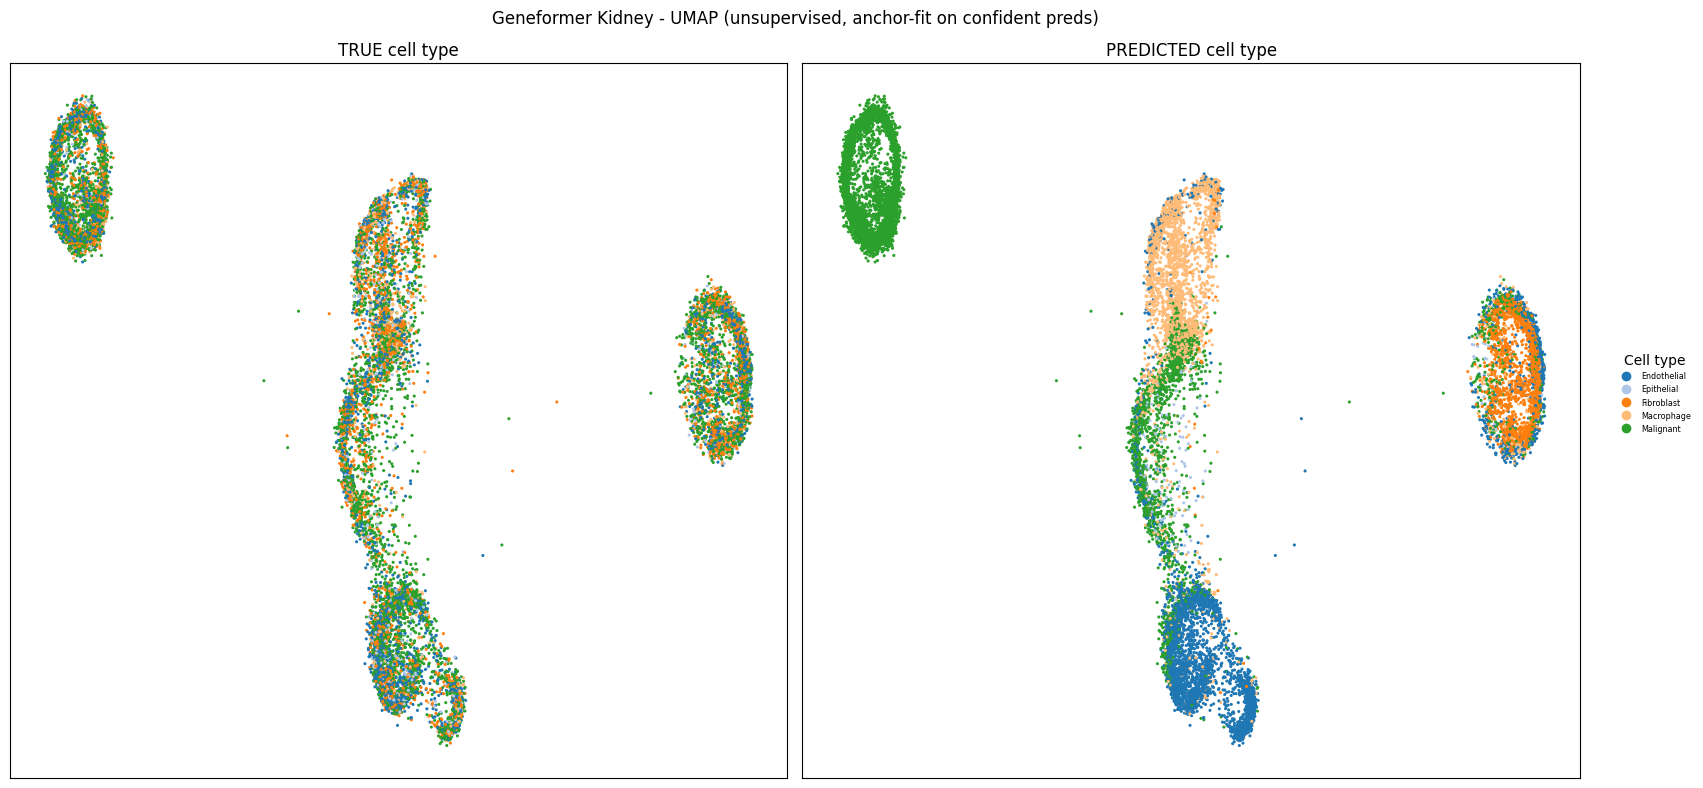

Saved combined figure with legend to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_baseline/model_outputs/geneformer_kidney_umap_true_pred_with_legend_model_v1_full_unsup_anchor_confident.png


In [2]:
# Standalone: Unsupervised UMAP anchored on high-confidence predictions (balanced)
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

try:
    MODEL_OUT
    RUN_TAG
except NameError:
    MODEL_OUT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_baseline/model_outputs')
    RUN_TAG = 'full'

# Load saved results
results_path = MODEL_OUT / f'geneformer_kidney_results_model_v1_{RUN_TAG}.pt'
print('Loading results from:', results_path)
try:
    res = torch.load(str(results_path), map_location='cpu', weights_only=False)
except TypeError:
    res = torch.load(str(results_path), map_location='cpu')
except Exception:
    from torch.serialization import add_safe_globals
    from numpy._core.multiarray import _reconstruct as _np_reconstruct
    add_safe_globals([_np_reconstruct])
    res = torch.load(str(results_path), map_location='cpu')

# Numpy arrays

def to_numpy(x):
    return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else np.asarray(x)

X_emb = to_numpy(res['cell_embs'])
logits = to_numpy(res.get('logits')) if 'logits' in res else None
labels_encoded = to_numpy(res['labels']).astype(int)
preds_arr = to_numpy(res['preds']).astype(int)
class_names = list(map(str, np.array(res['class_names'])))

# Build a balanced anchor set using most confident predictions (no true labels used)
if logits is None:
    # Fall back to distances in embedding space per class centroid
    centroids = np.vstack([X_emb[preds_arr==c].mean(axis=0) for c in np.unique(preds_arr)])
    dists = ((X_emb[:,None,:]-centroids[None,:,:])**2).sum(axis=2)
    conf = dists.min(axis=1)  # smaller is more confident (closer to some centroid)
    conf = -conf
else:
    # Confidence = margin between top1 and top2 softmax
    z = logits - logits.max(axis=1, keepdims=True)
    probs = np.exp(z); probs /= probs.sum(axis=1, keepdims=True)
    top2 = np.partition(probs, -2, axis=1)[:, -2:]
    conf = top2[:,1] - top2[:,0]  # p_max - p_second

rng = np.random.RandomState(0)
unique_preds = np.unique(preds_arr)
per_class = min(2500, *[np.sum(preds_arr==c) for c in unique_preds])
anchor_idx = []
for c in unique_preds:
    idx_c = np.where(preds_arr==c)[0]
    # take highest-confidence per class
    take = min(per_class, len(idx_c))
    sel = idx_c[np.argsort(conf[idx_c])[-take:]]
    # small random jitter selection for diversity
    if len(sel) > 2000:
        sel = rng.choice(sel, size=2000, replace=False)
    anchor_idx.append(sel)
anchor_idx = np.sort(np.concatenate(anchor_idx))
print(f'Anchor set size: {len(anchor_idx)} across {len(unique_preds)} classes')

# Optional preprocessing: scale+PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
Xs = StandardScaler(with_mean=True, with_std=True).fit_transform(X_emb)
Xp = PCA(n_components=min(50, Xs.shape[1]), random_state=0).fit_transform(Xs)

# Fit UMAP on anchors only (unsupervised), transform everyone
import umap
reducer = umap.UMAP(n_neighbors=30, min_dist=0.2, metric='cosine', init='random', n_epochs=1000, random_state=0)
reducer.fit(Xp[anchor_idx])
emb2d = reducer.transform(Xp)
method_used = 'UMAP (unsupervised, anchor-fit on confident preds)'

# Plot
class_arr = np.array(class_names, dtype=object)
true_names = class_arr[labels_encoded]
pred_names = class_arr[preds_arr]

PLOT_MAX = 50000
plot_idx = np.arange(emb2d.shape[0]) if emb2d.shape[0] <= PLOT_MAX else np.sort(rng.choice(emb2d.shape[0], PLOT_MAX, replace=False))

palette = dict(zip(class_names, sns.color_palette('tab20', n_colors=len(class_names))))

coords_path = MODEL_OUT / f'geneformer_kidney_umap_coords_model_v1_{RUN_TAG}_unsup_anchor_confident.csv'
coords_df = pd.DataFrame({'x': emb2d[:,0], 'y': emb2d[:,1], 'true': true_names, 'pred': pred_names})
coords_df.to_csv(coords_path, index=False)
print('Saved 2D coords to:', coords_path)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.scatterplot(ax=axes[0], x=emb2d[plot_idx,0], y=emb2d[plot_idx,1], hue=true_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[0].set_title('TRUE cell type'); axes[0].set_xlabel(''); axes[0].set_ylabel(''); axes[0].set_xticks([]); axes[0].set_yticks([])

sns.scatterplot(ax=axes[1], x=emb2d[plot_idx,0], y=emb2d[plot_idx,1], hue=pred_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[1].set_title('PREDICTED cell type'); axes[1].set_xlabel(''); axes[1].set_ylabel(''); axes[1].set_xticks([]); axes[1].set_yticks([])

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=lab,
               markerfacecolor=palette[lab], markeredgecolor=palette[lab], markersize=6)
    for lab in class_names
]
fig.legend(handles=handles, labels=class_names, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False, fontsize='xx-small', title='Cell type')
fig.suptitle(f'Geneformer Kidney - {method_used}', y=0.98)

png_path = MODEL_OUT / f'geneformer_kidney_umap_true_pred_with_legend_model_v1_{RUN_TAG}_unsup_anchor_confident.png'
plt.tight_layout(); fig.savefig(png_path, dpi=200, bbox_inches='tight'); plt.show()
print('Saved combined figure with legend to:', png_path)
